# kaggleのコンペで、ランダムフォレスト回帰を試してみる。


[こちら](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)で作成した特徴量をそのまま使って、ランダムフォレスト回帰をする

In [1]:
import pandas as pd
import numpy as np

# 1.データの読み込み

In [2]:
data = pd.read_pickle('./data/data.pkl')

data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

# 2.データの分割

In [3]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [4]:
# ガーベージコレクションをして、メモリを整理
import gc
del data
gc.collect();

# 3.学習

In [5]:
'''
ランダムフォレスト回帰
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
'''
from sklearn.ensemble import RandomForestRegressor
import time

ts = time.time()

model = RandomForestRegressor(
    n_estimators=10
    , criterion='mse'
    , max_depth = 15
    , min_samples_split = 2
    , max_features = 'sqrt' 
    , n_jobs=-1 # 全コアを利用する。
    , verbose=1 # 学習過程を表示してほしい 
    )

model.fit(X_train , Y_train)

time.time() - ts

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


68.80450105667114

# 4.評価
各特徴量の重要度、推論精度を確認する

1   date_item_city_avg_item_cnt_lag_1   0.169148496178
2   item_cnt_month_lag_1   0.153614655266
3   date_item_avg_item_cnt_lag_1   0.093825630873
4   date_shop_cat_avg_item_cnt_lag_1   0.0658612784733
5   item_cnt_month_lag_2   0.0637362699127
6   item_cnt_month_lag_3   0.0582840684745
7   item_category_id   0.0407508116705
8   date_shop_avg_item_cnt_lag_1   0.0301501835168
9   item_first_sale   0.0238581125024
10   date_item_avg_item_cnt_lag_3   0.0225622419311
11   subtype_code   0.0218000240349
12   item_cnt_month_lag_6   0.021265268575
13   date_item_avg_item_cnt_lag_2   0.0206355178402
14   item_id   0.0205929422938
15   date_cat_avg_item_cnt_lag_1   0.0190969106307
16   date_item_avg_item_cnt_lag_6   0.0182997606477
17   type_code   0.0174217427218
18   month   0.0167388028205
19   delta_price_lag   0.0131948186
20   shop_id   0.0124621644581
21   date_shop_avg_item_cnt_lag_2   0.010127104277
22   date_block_num   0.0100500709907
23   item_shop_first_sale   0.00986157318752
24  

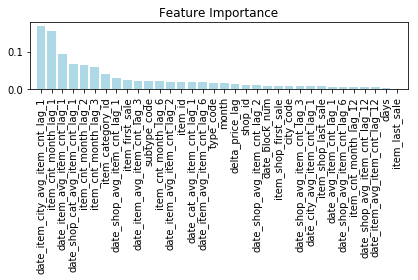

In [6]:
#特徴量の重要度
import matplotlib.pyplot as plt
%matplotlib inline


feature = model.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.loc[:, 'number']

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

In [7]:
# 評価指標を確認（1に近い方がいい）
print('train:{}'.format(model.score(X_train, Y_train)))
print('val:{}'.format(model.score(X_valid, Y_valid)))


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.3s finished


train:0.6075665842458582
val:0.3606105899057156


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


# 5.ベイズ最適化

[こちら](https://www.kumilog.net/entry/bayesian-optimization)を参考に

In [8]:
!conda install -c conda-forge scikit-optimize --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /anaconda3

  added / updated specs: 
    - scikit-optimize


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scipy-1.0.0                |   py36h1de22e9_0        15.0 MB
    conda-4.5.12               |        py36_1000         655 KB  conda-forge
    scikit-optimize-0.5.2      |             py_0          51 KB  conda-forge
    ca-certificates-2018.11.29 |       ha4d7672_0         143 KB  conda-forge
    openssl-1.0.2p             |       h470a237_2         2.9 MB  conda-forge
    certifi-2018.11.29         |        py36_1000         145 KB  conda-forge
    numpy-1.14.2               |   py36ha9ae307_0         3.9 MB
    matplotlib-2.2.2

In [20]:
# ベイズ最適化のパラメータと関数を指定

# 探索範囲の指定
spaces = [
    (2, 5) # n_estimators
    , (3, 10) # max_depth
    , ['sqrt', 'log2'] # max_features
    # ['linear', 'poly', 'rbf']
]

# ブラックボックス関数
def f(x):
    model = RandomForestRegressor(
        n_estimators=x[0]
        , criterion='mse'
        , max_depth = x[1]
        , min_samples_split = 2
        , max_features = x[2] 
        , n_jobs=-1 # 全コアを利用する。
    )
    model.fit(X_train, Y_train)
    return -1 * model.score(X_valid, Y_valid) # gp_minimizeでは最小化をするので、負の値にしておく。


In [23]:
# ベイズ最適化を実行
# https://scikit-optimize.github.io/notebooks/bayesian-optimization.html

from skopt import gp_minimize
res = gp_minimize(
    f 
    , spaces
    , acq_func="LCB" # 分散が大きいパラメータも探索してほしいので、「LCB」を指定
    , n_calls=10 # 試行回数
    , verbose=True
    , n_jobs=-1
)

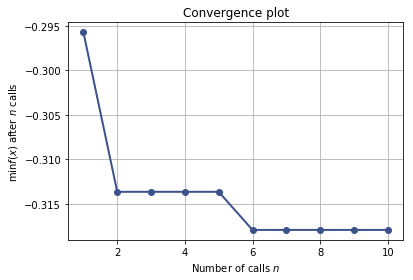

In [24]:
# 試行回数と評価指標の関係を可視化

from skopt.plots import plot_convergence
plot_convergence(res)

In [46]:
# 最良の結果の時のパラメータ

print('best_hyperparam:{}'.format(res.x))
print('best_score:{}'.format(res.fun))

best_hyperparam:[4, 9, 'log2']
best_score:-0.3179080059170447


In [48]:
# 最良の結果で学習し直し。
# 「model」には、最後の学習時の結果が残っているので再学習が必要

model = RandomForestRegressor(
    n_estimators=4
    , criterion='mse'
    , max_depth = 9
    , min_samples_split = 2
    , max_features = 'log2' 
    , n_jobs=-1 # 全コアを利用する。
)
model.fit(X_train, Y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# 6.サブミッション用に整形

In [49]:
import pickle

test  = pd.read_csv('./data/test.csv.gz', compression='gzip').set_index('ID')

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('rfr_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))